In [1]:
import tensorflow as tf 

2025-03-06 16:04:30.513899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Centralized setting 

In [204]:
import numpy as np 
from sksurv.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split

# Load dataset 
X, y = load_breast_cancer()

# Unpack 
event, duration = zip(*y)
e = np.array(event)
t = np.array(duration)

# Drop columns that are not numerical 
X = X[X.columns[X.dtypes != "category"]]

# Train-test splitting 
train_idx, test_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.25, random_state=42, stratify=e.astype(int)
)
X_train, X_test = X.iloc[train_idx].to_numpy(), X.iloc[test_idx].to_numpy()
y_train, y_test = y[train_idx], y[test_idx]
e_train, e_test = e[train_idx], e[test_idx]
t_train, t_test = t[train_idx], t[test_idx]

X_train.shape, X_test.shape 

((148, 78), (50, 78))

In [205]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [206]:
x_train = np.log(t_train)
x_test = np.log(t_test)

knots = np.percentile(x_train, np.linspace(0, 1, 4) * 100)
knots

array([5.59471138, 8.1056094 , 8.54791636, 9.11690843])

In [207]:
def spline_basis(x, knots, j):
    k_min = min(knots)
    k_max = max(knots)
    phi = (k_max - knots[j]) / (k_max - k_min)
    return np.maximum(0, x - knots[j]) ** 3 - phi * np.maximum(0, x - k_min) ** 3 - (1 - phi) * np.maximum(0, x - k_max) ** 3

S1_train = spline_basis(x_train, knots, j=1) 
S2_train = spline_basis(x_train, knots, j=2) 
S3_train = spline_basis(x_train, knots, j=3) 

# Spline design matrix 
D_train = np.transpose(np.vstack([np.ones_like(x_train), x_train, S1_train, S2_train, S3_train]))
D_train.shape 

(148, 5)

In [208]:
def spline_basis_derivative(x, knots, j):
    k_min = min(knots)
    k_max = max(knots)
    phi = (k_max - knots[j]) / (k_max - k_min)
    return 3 * np.maximum(0, x - knots[j]) ** 2 - 3 * phi * np.maximum(0, x - k_min) ** 2 - 3 * (1 - phi) * np.maximum(0, x - k_max) ** 2

dS1_train = spline_basis_derivative(x_train, knots, j=1) 
dS2_train = spline_basis_derivative(x_train, knots, j=2) 
dS3_train = spline_basis_derivative(x_train, knots, j=3) 

# Derivative spline design matrix 
dD_train = np.transpose(np.vstack([np.zeros_like(x_train), np.ones_like(x_train), dS1_train, dS2_train, dS3_train]))
dD_train.shape 

(148, 5)

In [221]:
beta = tf.Variable(tf.random.uniform(shape=[1, int(X.shape[1])], seed=42))
gamma = tf.Variable(tf.random.uniform(shape=[1, int(D_train.shape[1])], seed=42))

X_train_tf = tf.cast(X_train, dtype=tf.float32)
D_train_tf = tf.cast(D_train, dtype=tf.float32)
dD_train_tf = tf.cast(dD_train, dtype=tf.float32)

e_train_tf = tf.cast(e_train[:, None], dtype=tf.float32)
t_train_tf = tf.cast(t_train[:, None], dtype=tf.float32)


def loss():    
    eta = D_train_tf @ tf.transpose(gamma) + X_train_tf @ tf.transpose(beta)
 
    f1 = 1 / t_train_tf * dD_train_tf @ tf.transpose(gamma) * tf.math.exp(eta - tf.math.exp(eta))
    f2 = 1 / (1 + tf.math.exp(eta))

    return e_train_tf * f1 + (1 - e_train_tf) * f2
    

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
for epoch in tf.range(100):

    with tf.GradientTape() as tape:
        loss_value = loss()
    
    # Compute gradients
    gradients = tape.gradient(loss_value, [gamma, beta])
    
    # Apply gradients to update gamma and beta
    optimizer.apply_gradients(zip(gradients, [gamma, beta]))

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy().mean()}")


from sksurv.metrics import concordance_index_censored
r_train = (X_train @ np.transpose(beta.numpy())).squeeze()
r_test = (X_test @ np.transpose(beta.numpy())).squeeze()
print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))

Epoch 0, Loss: 0.20553365349769592
Epoch 5, Loss: 0.0849948450922966
Epoch 10, Loss: 0.037992723286151886
Epoch 15, Loss: 0.025498099625110626
Epoch 20, Loss: 0.02056930400431156
Epoch 25, Loss: 0.018129758536815643
Epoch 30, Loss: 0.01677994802594185
Epoch 35, Loss: 0.01595981977880001
Epoch 40, Loss: 0.015419392846524715
Epoch 45, Loss: 0.015038267709314823
Epoch 50, Loss: 0.014753937721252441
Epoch 55, Loss: 0.01453155092895031
Epoch 60, Loss: 0.014350412413477898
Epoch 65, Loss: 0.014197483658790588
Epoch 70, Loss: 0.014064104296267033
Epoch 75, Loss: 0.013944213278591633
Epoch 80, Loss: 0.01383331511169672
Epoch 85, Loss: 0.013727864250540733
Epoch 90, Loss: 0.013624856248497963
Epoch 95, Loss: 0.013521537184715271
(0.48294556132821326, 2138, 2289, 0, 0)
(0.6082677165354331, 309, 199, 0, 0)


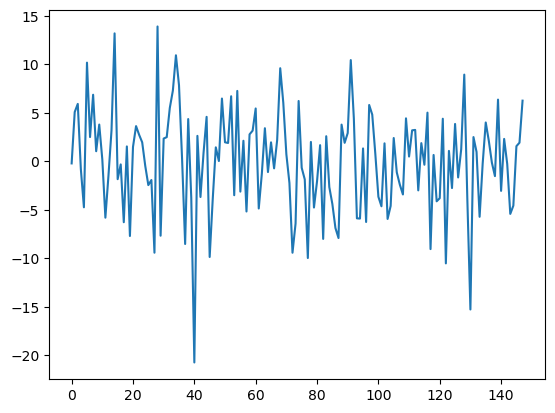

In [222]:
import matplotlib.pyplot as plt 
#eta = D_train @ np.transpose(gamma.numpy()) + X_train @ np.transpose(beta.numpy())
#plt.plot(np.exp(-np.exp(eta)).squeeze())
plt.plot(X_train @ np.transpose(beta.numpy()))

# De-centralized setting 

In [223]:
class Client:
    
    def __init__(self, p, q):
        self.beta = np.random.uniform(size=(1, p))
        self.gamma = np.random.uniform(size=(1, q))

    def get_params(self):
        return self.beta, self.gamma 

    def set_params(self, beta, gamma):
        self.beta = beta 
        self.gamma = gamma 

    def fit(self, X, D, dD, t, e):
        
        def _loss():    
            eta = D @ tf.transpose(gamma) + X @ tf.transpose(beta)
            f1 = 1 / t * dD @ tf.transpose(gamma) * tf.math.exp(eta - tf.math.exp(eta))
            f2 = 1 / (1 + tf.math.exp(eta))        
            return e * f1 + (1 - e) * f2

        beta = tf.Variable(self.beta, dtype=tf.float32, name="beta")
        gamma = tf.Variable(self.gamma, dtype=tf.float32, name="gamma")

        X = tf.cast(X, dtype=tf.float32)
        D = tf.cast(D, dtype=tf.float32)
        dD = tf.cast(dD, dtype=tf.float32)

        t = tf.cast(t, dtype=tf.float32)
        e = tf.cast(e, dtype=tf.float32)

        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        for epoch in tf.range(5):

            with tf.GradientTape() as tape:
                loss_value = _loss()

            gradients = tape.gradient(loss_value, [gamma, beta])
            optimizer.apply_gradients(zip(gradients, [gamma, beta]))
    
        self.beta = beta.numpy()
        self.gamma = gamma.numpy()

        self.loss = float(loss_value.numpy().mean())

In [ ]:
n_participants = 4

clients = [Client(X.shape[1], D_train.shape[1]) for _ in range(n_participants)]

idx = np.array_split(np.arange(X_train.shape[0]), n_participants)

for epoch in range(100):

    losses, betas, gammas = [], [], []
    for i, cli in enumerate(clients):
        cli.fit(X_train[idx[i]], D_train[idx[i]], dD_train[idx[i]], t_train[[idx[i]], None], e_train[[idx[i]], None])

        beta_i, gamma_i = cli.get_params()
        betas.append(beta_i)
        gammas.append(gamma_i)
        
        losses.append(cli.loss)

    beta_avg = sum(betas) / len(betas)
    gamma_avg = sum(gammas) / len(gammas)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {np.mean(losses)}")
        
    for i, cli in enumerate(clients):
        cli.set_params(beta_avg, gamma_avg)

Epoch 0, Loss: 0.10041780769824982
Epoch 5, Loss: 0.013440977752907202
Epoch 10, Loss: 0.0013327107826626161
Epoch 15, Loss: 0.000501495206663094
Epoch 20, Loss: 0.00029313719232959556
Epoch 25, Loss: 0.00020693078886324656
Epoch 30, Loss: 0.0001607328829322796


In [ ]:
beta_avg, gamma_avg = 0, 0
for i, cli in enumerate(clients):
    beta_i, gamma_i = cli.get_params()
    
    beta_avg += beta_i
    gamma_avg += gamma_i

beta_avg /= n_participants
gamma_avg /= n_participants

# Comparison

In [ ]:
_, axis = plt.subplots(1, 1)
axis.plot((X_train @ np.transpose(beta.numpy())).squeeze())
axis.plot((X_train @ np.transpose(beta_avg)).squeeze())

In [ ]:
_, axis = plt.subplots(1, 1)
axis.plot((D_train @ np.transpose(gamma.numpy())).squeeze())
axis.plot((D_train @ np.transpose(gamma_avg)).squeeze())

In [ ]:
r_train = (X_train @ np.transpose(beta.numpy())).squeeze()
r_test = (X_test @ np.transpose(beta.numpy())).squeeze()

print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))

In [ ]:
r_train = (X_train @ np.transpose(beta_avg)).squeeze()
r_test = (X_test @ np.transpose(beta_avg)).squeeze()

print(concordance_index_censored(e_train, t_train, r_train))
print(concordance_index_censored(e_test, t_test, r_test))